In [37]:
from scipy.special import comb
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [38]:
def ensemble_error (n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2.))
    probs = [comb(n_classifier, k)*(error**k)*(1-error)**(n_classifier-k) for k in range (k_start, n_classifier + 1)]
    return sum(probs)

ensemble_error(n_classifier=11, error=0.25)

0.03432750701904297

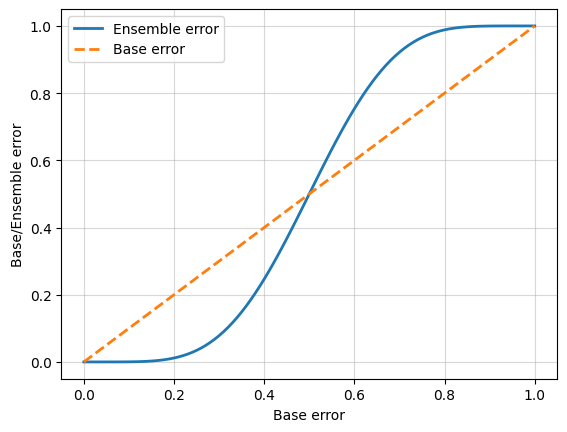

In [39]:
error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error) for error in error_range]
plt.plot(error_range, ens_errors, label='Ensemble error', lw=2)
plt.plot(error_range, error_range, linestyle='--', label='Base error', lw=2)
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)

MAJORITY VOTE CLASSIFIER

In [40]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin, clone
from sklearn.preprocessing import LabelEncoder
import six
from sklearn.pipeline import _name_estimators
import operator

In [41]:
class MajorityVoteClassifier (BaseEstimator, ClassifierMixin):
    """ A majority vote ensemble classifier 
    
    Parameters
    ----------
    classifiers: array-like, shape = [n_classifiers]
        Different classifiers for the ensemble
    
    vote: str, {'classlabel', 'probability'}
        Default: 'classlabel'
        if 'classlabel' the prediction is based on the argmax of the class
        labels. Else if 'probability', the argmax of the sum of probabilities
        is used to predict the class label
        (recommended for calibrated classifiers).
    weights: array-like, shape = [n_classifiers]
        Optional, default: None
        If a list of 'int' or 'float'values are provided the classifiers are
        weighted by importance; uses uniform weights if 'weights=None'    
    """

    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
    
    def fit(self, X, y):
        """Fit classifers.
        
        Parameters
        ----------
        X: {array-like, sparse matrix},
            shape = [n_samples, n_features]
            Matrix of training samples
        
        y: array-like, shape = [n_samples]
            vector of target class labels
        
        Returns
        -------
        self: object
        """

        # Use LabelEncoder to ensure class labels start
        # with 0, whcih is important for np.argmax
        # call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    def predict(self, X):
        """ Predict class labels for X

        Parameters
        ----------
        X: {array-like, sparse matrix},
            Shape = [n_samples, n_features]
            Matrix of training samples
        
        Returns
        -------
        maj_vote: array-liek, shape=[n_samples]
            predicted class label
        """

        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else: # 'classlabel' vote
            # collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, weights=self.weights)), axis=1, arr=predictions)
            maj_vote = self.lablenc_.inverse_transform(maj_vote)
            return maj_vote
        
    def predict_proba(self, X):
        """ Predict class probabilities for X

        Parameters
        ----------
        X: {array-like, sparse matrix}
            shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples
            and n_features is the number of features

        Returns
        -------
        avg_proba: array-like
            shape = [n_samples, n_classes]
            weighted average probability for each class per sample
        """    
        probas = np.array([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' %(name, key)] = value
            return out

In [42]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1, stratify=y)

# the classifiers we will use are Logistic regression, Decision Tree classifier, and KNN classifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])

clf_labels = ['Logistic regression', 'Decision Tree', 'KNN']
print('10 fold cross-validation:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print('ROC AUC: %0.2f (+/- %0.2f) [%s]' %(scores.mean(), scores.std(), label))

10 fold cross-validation:

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision Tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]


In [44]:
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print('Accuracy: %0.2f (+/- %0.2f) [%s]' %(scores.mean(), scores.std(), label))

Accuracy: 0.92 (+/- 0.15) [Logistic regression]
Accuracy: 0.87 (+/- 0.18) [Decision Tree]
Accuracy: 0.85 (+/- 0.13) [KNN]
Accuracy: 0.98 (+/- 0.05) [Majority voting]


ROC Curves from the test set to check MajorityVoteClassifier

Text(0, 0.5, 'True positive rate(TPR)')

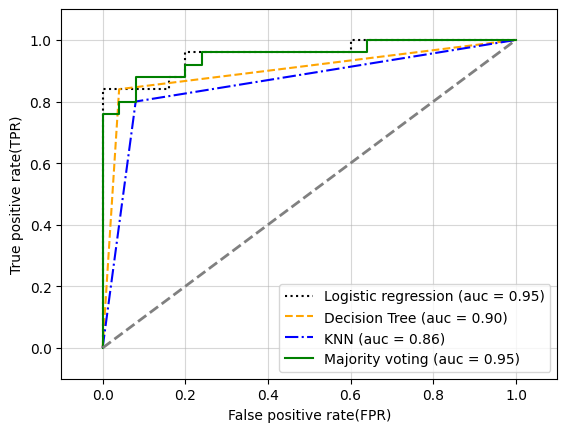

In [45]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls in zip (all_clf, clf_labels, colors, linestyles):
    # assuming the label of the positive class is 1
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label='%s (auc = %0.2f)' %(label, roc_auc))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate(FPR)')
plt.ylabel('True positive rate(TPR)')

Decision regions

Text(-10.5, 4.5, 'Petal length(std.)')

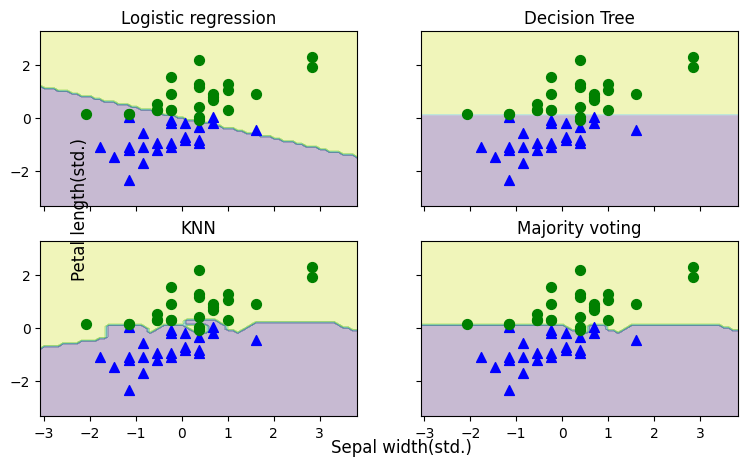

In [46]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

from itertools import product
x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row', figsize=(9,5))
for idx, clf, tt in zip(product([0, 1], [0, 1]), all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], X_train_std[y_train==0, 1], c='blue', marker='^', s=50)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], X_train_std[y_train==1, 1], c='green', marker='o', s=50)
    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -4.5, s='Sepal width(std.)', ha='center', va='center', fontsize=12)
plt.text(-10.5, 4.5, s='Petal length(std.)', ha='center', va='center', fontsize=12, rotation=90)

Tuning individual classifiers

In [47]:
mv_clf.get_params()

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('sc', StandardScaler()),
  ['clf', LogisticRegression(C=0.001, random_state=1)]],
 'pipeline-1__verbose': False,
 'pipeline-1__sc': StandardScaler(),
 'pipeline-1__clf': LogisticRegression(C=0.001, random_state=1),
 'pipeline-1__sc__copy': True,
 'pipeline-1__sc__with_mean': True,
 'pipeline-1__sc__with_std': True,
 'pipeline-1__clf__C': 0.001,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_intercept': True,
 'pipeline-1__clf__intercept_scaling': 1,
 'pipeline-1__clf__l1_ratio': None,
 'pipeline-1__clf__max_iter': 100,
 'pipeline-1__clf__m

In [48]:
from sklearn.model_selection import GridSearchCV
params = {'decisiontreeclassifier__max_depth': [1, 2], 'pipeline-1__clf__C': [0.001, 0.1, 100.0]}
grid = GridSearchCV(estimator=mv_clf, param_grid=params, cv=10, scoring='roc_auc')
grid.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=MajorityVoteClassifier(classifiers=[Pipeline(steps=[('sc',
                                                                            StandardScaler()),
                                                                           ['clf',
                                                                            LogisticRegression(C=0.001,
                                                                                               random_state=1)]]),
                                                           DecisionTreeClassifier(criterion='entropy',
                                                                                  max_depth=1,
                                                                                  random_state=0),
                                                           Pipeline(steps=[('sc',
                                                                            StandardScaler()),
                                                                           ['clf',
                                                                            KNeighborsClassifier(n_neighbors=1)]])]),
             param_grid={'decisiontreeclassifier__max_depth': [1, 2],
                         'pipeline-1__clf__C': [0.001, 0.1, 100.0]},
             scoring='roc_auc')

In [52]:
cv_keys = ('mean_test_score', 'std_test_score', 'params')

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print('%0.3f+/-%0.2f %r' %(grid.cv_results_[cv_keys[0]][r], grid.cv_results_[cv_keys[1]][r]/2.0, grid.cv_results_[cv_keys[2]][r]))

0.983+/-0.02 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.983+/-0.02 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.967+/-0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.983+/-0.02 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.983+/-0.02 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.967+/-0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [53]:
print('best parameters: %s' % grid.best_params_)

best parameters: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}


In [54]:
print('Accuracy: %0.2f' %grid.best_score_)

Accuracy: 0.98
